# face_generation gan

In [1]:
!wget https://s3-us-west-1.amazonaws.com/udacity-dlnfd/datasets/celeba.zip

--2024-02-23 20:57:08--  https://s3-us-west-1.amazonaws.com/udacity-dlnfd/datasets/celeba.zip
Resolving s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)... 52.219.112.184, 52.219.121.88, 52.219.220.176, ...
Connecting to s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)|52.219.112.184|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1443490838 (1.3G) [application/zip]
Saving to: ‘celeba.zip.1’

celeba.zip.1        100%[===================>]   1.34G  14.8MB/s    in 57s     

2024-02-23 20:58:06 (24.0 MB/s) - ‘celeba.zip.1’ saved [1443490838/1443490838]



In [2]:
!unzip celeba.zip

Archive:  celeba.zip
replace img_align_celeba/000001.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [3]:
import tensorflow as tf
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import random
from glob import glob
from PIL import Image
from IPython import display

In [4]:
train_dir = "/content/img_align_celeba/"
filenames = [train_dir + filename for filename in os.listdir(train_dir)]

In [5]:
filenames[:10]

['/content/img_align_celeba/188696.jpg',
 '/content/img_align_celeba/025700.jpg',
 '/content/img_align_celeba/187040.jpg',
 '/content/img_align_celeba/059456.jpg',
 '/content/img_align_celeba/131352.jpg',
 '/content/img_align_celeba/014220.jpg',
 '/content/img_align_celeba/187436.jpg',
 '/content/img_align_celeba/153738.jpg',
 '/content/img_align_celeba/091916.jpg',
 '/content/img_align_celeba/183769.jpg']

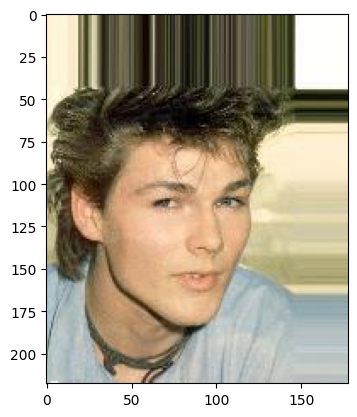

In [6]:
img = mpimg.imread(filenames[0])
plt.imshow(img)

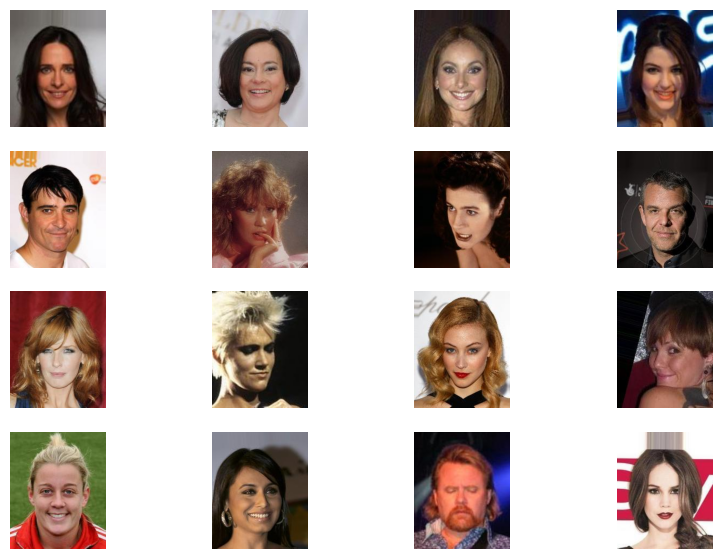

In [7]:
rand_seq = random.sample(range(0, len(filenames)-1), 16)
fig, axes = plt.subplots(4, 4, figsize=(10, 7))
for ax, num in zip(axes.flatten(), rand_seq):
  img = mpimg.imread(filenames[num])
  ax.imshow(img)
  ax.axis(False)

## data preprocessing

In [8]:
def get_image(image_path, width, height, mode):
    """
    Read image from image_path
    :param image_path: Path of image
    :param width: Width of image
    :param height: Height of image
    :param mode: Mode of image
    :return: Image data
    """
    image = Image.open(image_path)

    if image.size != (width, height):  # HACK - Check if image is from the CELEBA dataset
        # Remove most pixels that aren't part of a face
        face_width = face_height = 108
        j = (image.size[0] - face_width) // 2
        i = (image.size[1] - face_height) // 2
        image = image.crop([j, i, j + face_width, i + face_height])
        image = image.resize([width, height], Image.BILINEAR)

    return np.array(image.convert(mode))

def get_batch(image_files, width, height, mode):
    data_batch = np.array(
        [get_image(sample_file, width, height, mode) for sample_file in image_files]).astype(np.float32)

    # Make sure the images are in 4 dimensions
    if len(data_batch.shape) < 4:
        data_batch = data_batch.reshape(data_batch.shape + (1,))

    return data_batch


class Dataset(object):
    """
    Dataset
    """
    def __init__(self,data_files):
        """
        Initalize the class
        :param dataset_name: Database name
        :param data_files: List of files in the database
        """

        IMAGE_WIDTH = 28
        IMAGE_HEIGHT = 28

        self.image_mode = 'RGB'
        image_channels = 3


        self.data_files = data_files
        self.shape = len(data_files), IMAGE_WIDTH, IMAGE_HEIGHT, image_channels

    def get_batches(self, batch_size):
        """
        Generate batches
        :param batch_size: Batch Size
        :return: Batches of data
        """
        IMAGE_MAX_VALUE = 255

        current_index = 0
        while current_index + batch_size <= self.shape[0]:
            data_batch = get_batch(
                self.data_files[current_index:current_index + batch_size],
                *self.shape[1:3],
                self.image_mode)

            current_index += batch_size

            yield data_batch / IMAGE_MAX_VALUE - 0.5

In [9]:
train_obj = Dataset(glob(os.path.join(train_dir, '*.jpg')))

In [10]:
BATCH_SIZE = 32
train_data = train_obj.get_batches(BATCH_SIZE)

In [11]:
train_sample = next(train_data)
train_sample.shape

(32, 28, 28, 3)

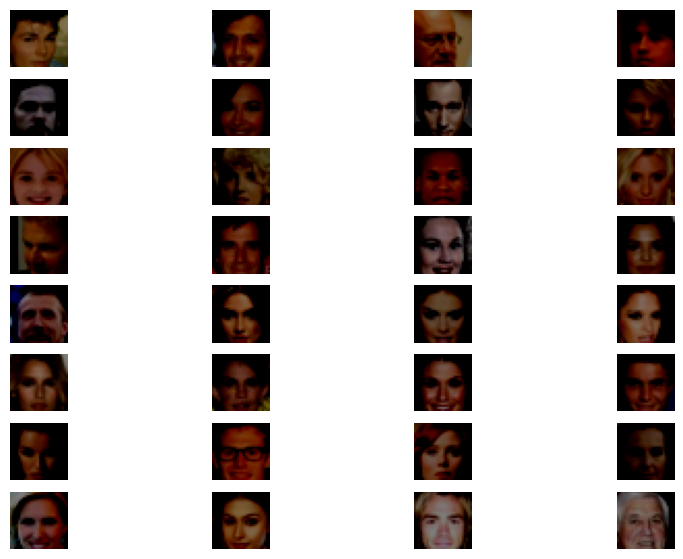

In [12]:
fig, axis = plt.subplots(8, 4, figsize=(10, 7))
for i, ax in enumerate(axis.flatten()):
  ax.imshow(train_sample[i])
  ax.axis(False)

## Create generator and discriminator

In [13]:
def generator_builder():
  model = tf.keras.Sequential()
  model.add(tf.keras.layers.Dense(7*7*256, input_shape=(100, ), use_bias=False))
  model.add(tf.keras.layers.BatchNormalization())
  model.add(tf.keras.layers.LeakyReLU())

  model.add(tf.keras.layers.Reshape((7, 7, 256)))

  model.add(tf.keras.layers.Conv2DTranspose(128, 5, strides=(1, 1), padding='same', use_bias=False))
  model.add(tf.keras.layers.BatchNormalization())
  model.add(tf.keras.layers.LeakyReLU())

  model.add(tf.keras.layers.Conv2DTranspose(64, 5, strides=(2, 2), padding='same', use_bias=False))
  model.add(tf.keras.layers.BatchNormalization())
  model.add(tf.keras.layers.LeakyReLU())

  model.add(tf.keras.layers.Conv2DTranspose(3, 5, strides=(2, 2), padding='same', use_bias=False))

  print(model.output_shape)
  return model

def discriminator_builder():
  model = tf.keras.Sequential()
  model.add(tf.keras.layers.Conv2D(64, 5, strides=2, padding='same'))
  model.add(tf.keras.layers.LeakyReLU())

  model.add(tf.keras.layers.Conv2D(128, 5, strides=2, padding='same'))
  model.add(tf.keras.layers.BatchNormalization())
  model.add(tf.keras.layers.LeakyReLU())

  model.add(tf.keras.layers.Conv2D(256, 5, strides=2, padding='same'))
  model.add(tf.keras.layers.BatchNormalization())
  model.add(tf.keras.layers.LeakyReLU())

  model.add(tf.keras.layers.Flatten())
  model.add(tf.keras.layers.Dense(1))

  return model

In [14]:
generator = generator_builder()
discriminator = discriminator_builder()

(None, 28, 28, 3)


## Loss function and optimizer

In [15]:
lr = 1e-4
epochs = 50
noise_dim = 100
num_examples_to_generate = 16
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [16]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
  real_loss = cross_entropy(tf.ones_like(real_output), real_output)
  fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)

  total_loss = real_loss + fake_loss
  return total_loss


def generator_loss(fake_output):
  return cross_entropy(tf.ones_like(fake_output), fake_output)

In [17]:
generator_optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=lr)

In [18]:
@tf.function
def train_step(images):
  noise = tf.random.normal([BATCH_SIZE, noise_dim])
  with tf.GradientTape() as disc_tape, tf.GradientTape() as gen_tape:
    generated_image = generator(noise, training=True)

    real_output = discriminator(images, training=True)
    fake_output = discriminator(generated_image, training=True)

    disc_loss = discriminator_loss(real_output, fake_output)
    gen_loss = generator_loss(fake_output)

  gen_gradient = gen_tape.gradient(gen_loss, generator.trainable_variables)
  disc_gradient = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

  generator_optimizer.apply_gradients(zip(gen_gradient, generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(disc_gradient, discriminator.trainable_variables))

In [19]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

In [20]:
def train(dataset, epochs):
  for epoch in range(epochs):
    for batch_images in dataset.get_batches(BATCH_SIZE):
      train_step(batch_images)
      display.clear_output(wait=True)
      print(f'epoch:{epoch+1}')
      generate_and_save_images(generator, epochs, seed)



In [ ]:
train(train_obj, epochs)

epoch:1
